In [1]:
# https://github.com/pytorch/vision/blob/main/gallery/transforms/helpers.py
import matplotlib.pyplot as plt
import torch
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

def plot(imgs, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    plt.tight_layout()
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            boxes = None
            masks = None
            if isinstance(img, tuple):
                img, target = img
                masks = target.Mask
            if boxes is not None:
                img = draw_bounding_boxes(img, boxes, colors="yellow", width=3)
            if masks is not None:
                img = draw_segmentation_masks(img, masks.to(torch.bool), colors=["green"] * masks.shape[0], alpha=.65)

            ax = axs[row_idx, col_idx]

            ax.imshow(img.permute(1, 2, 0).numpy(), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    

In [2]:
import torch
import matplotlib.pyplot as plt
plt.rcParams["savefig.bbox"] = 'tight'

from torchvision.transforms import v2
from torchvision.io import read_image, ImageReadMode
from transforms import CustomCrop
torch.manual_seed(1)

train_transforms = v2.Compose(
    [
        v2.RandomHorizontalFlip(),
        v2.RandomPerspective(),
        v2.RandomAffine(degrees=180, translate=(0.5, 0.5)),
        v2.RandomResizedCrop((256, 256), scale=(0.25, 1.0), antialias=True, ratio=(1.0, 1.0)),
        v2.RandomApply([v2.RandomResize(128, 256, antialias=True), v2.Resize((256, 256), antialias=True)]),
        v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    ]
)


wholebody_train_transforms = v2.Compose(
    [
        # v2.RandomHorizontalFlip(),
        # v2.RandomPerspective(),
        # v2.RandomRotation(180),
        CustomCrop((256, 512)),
        v2.Resize((256, 256), antialias=True),
        # v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    ]
)

img = read_image("data/'19/images/Int. (SNU)/0044.jpg")
mask = read_image("data/'19/labels/Int. (SNU)/동현/0044.png", ImageReadMode.GRAY)
wb = read_image("data/'20 Int. (SNU-adult)/images/NL/DSC00213.png")
print(f"{type(img) = }, {img.dtype = }, {img.shape = }")
print(f"{type(wb) = }, {wb.dtype = }, {wb.shape = }")

type(img) = <class 'torch.Tensor'>, img.dtype = torch.uint8, img.shape = torch.Size([3, 621, 621])
type(wb) = <class 'torch.Tensor'>, wb.dtype = torch.uint8, wb.shape = torch.Size([3, 3041, 1849])


<Figure size 640x480 with 0 Axes>

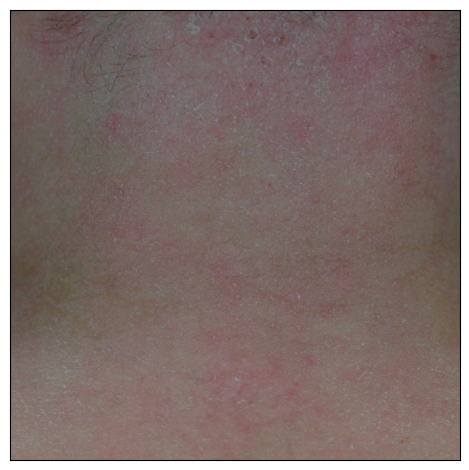

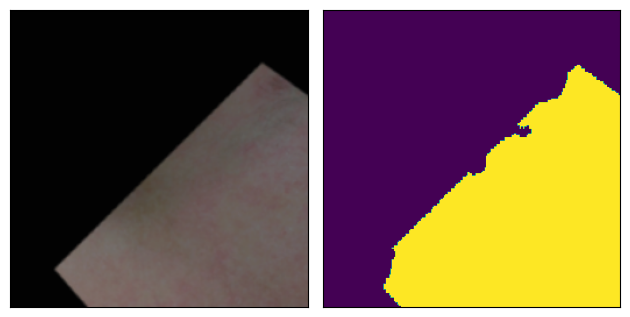

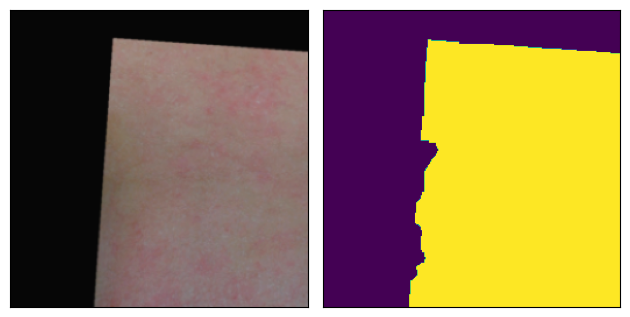

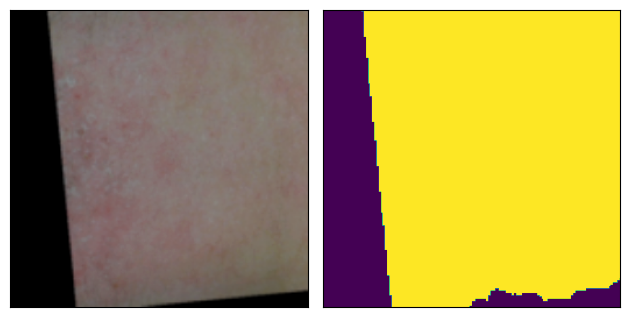

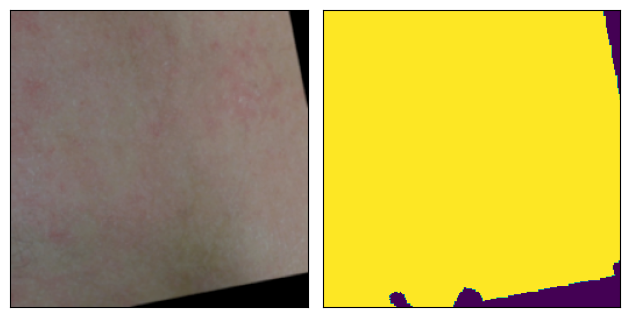

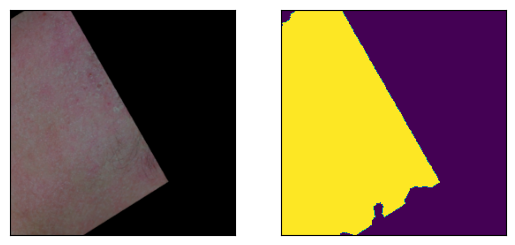

In [3]:
plot([img])

from torchvision import tv_tensors

mask = tv_tensors.Mask(mask)
for i in range(5):
    input = train_transforms(img, mask)
    plot(input)

<Figure size 640x480 with 0 Axes>

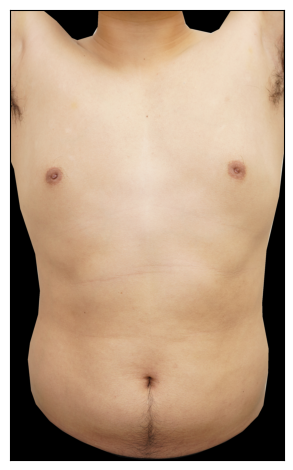

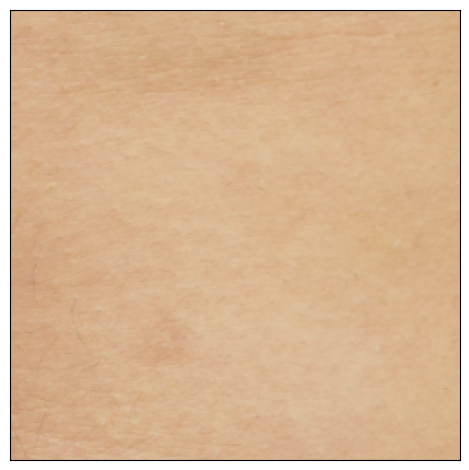

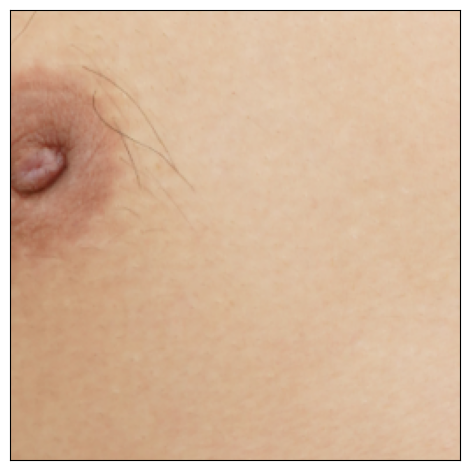

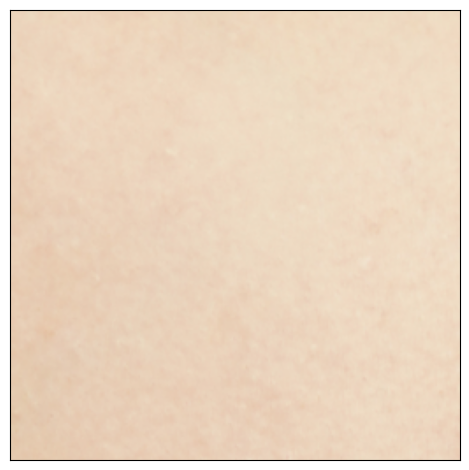

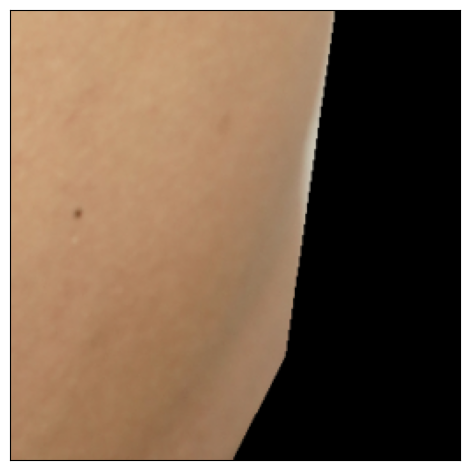

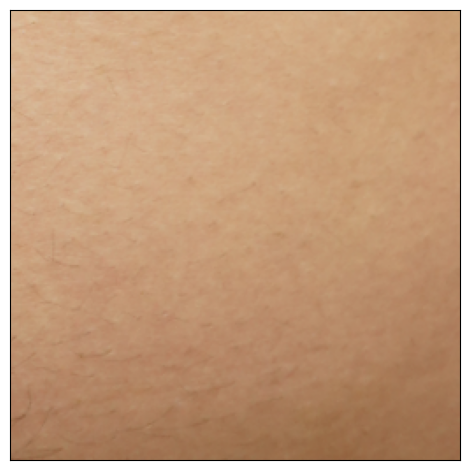

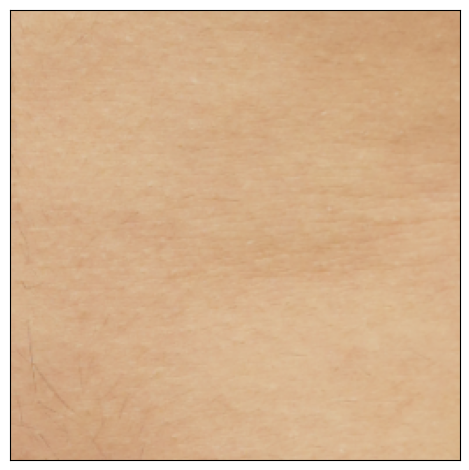

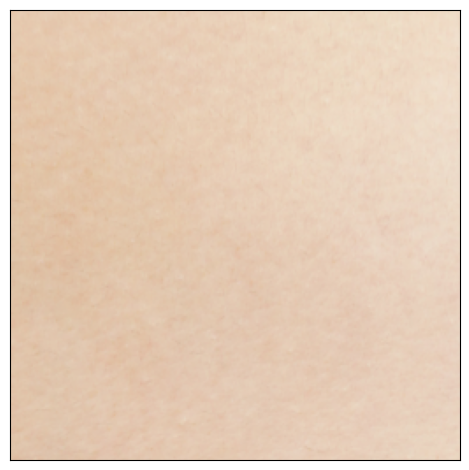

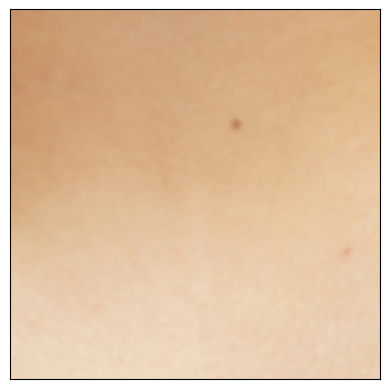

In [4]:
plot([wb])
for i in range(1):
    imgs = wholebody_train_transforms(wb)
    for j in range(len(imgs)):
        plot([imgs[j]])
        plt.savefig(f"figure/wholebodycrop_{j}.jpg")

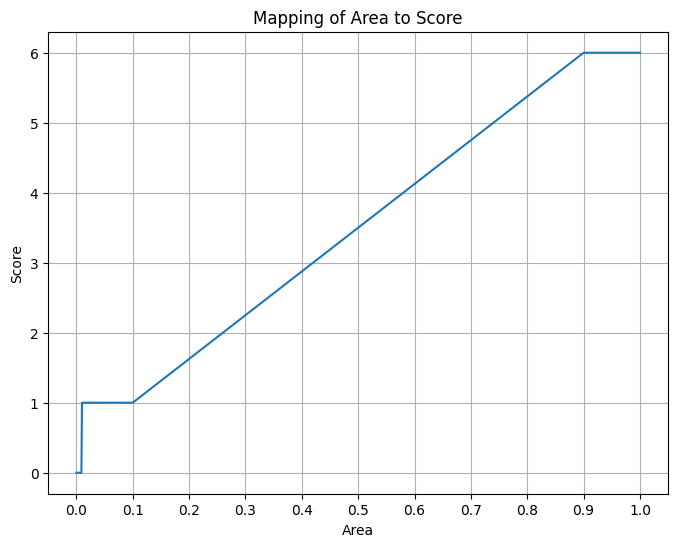

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def area2score(area):
    score = 6.25 * area + 0.375
    score[area > 0.9] = 6.
    score[area < 0.1] = 1.
    score[area < 0.01] = 0.
    return score

# Generate an array of area values from 0 to 1.0
area_values = np.linspace(0, 1.0, 1000)
score_values = area2score(area_values)

# Create a plot
plt.figure(figsize=(8, 6))
plt.plot(area_values, score_values, label='Score')
plt.xlabel('Area')
plt.ylabel('Score')
plt.title('Mapping of Area to Score')
plt.grid(True)

# Set x-axis ticks every 0.1
plt.xticks(np.arange(0, 1.1, 0.1))

plt.show()


/tmp/ipykernel_1170788/2122942737.py:32: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


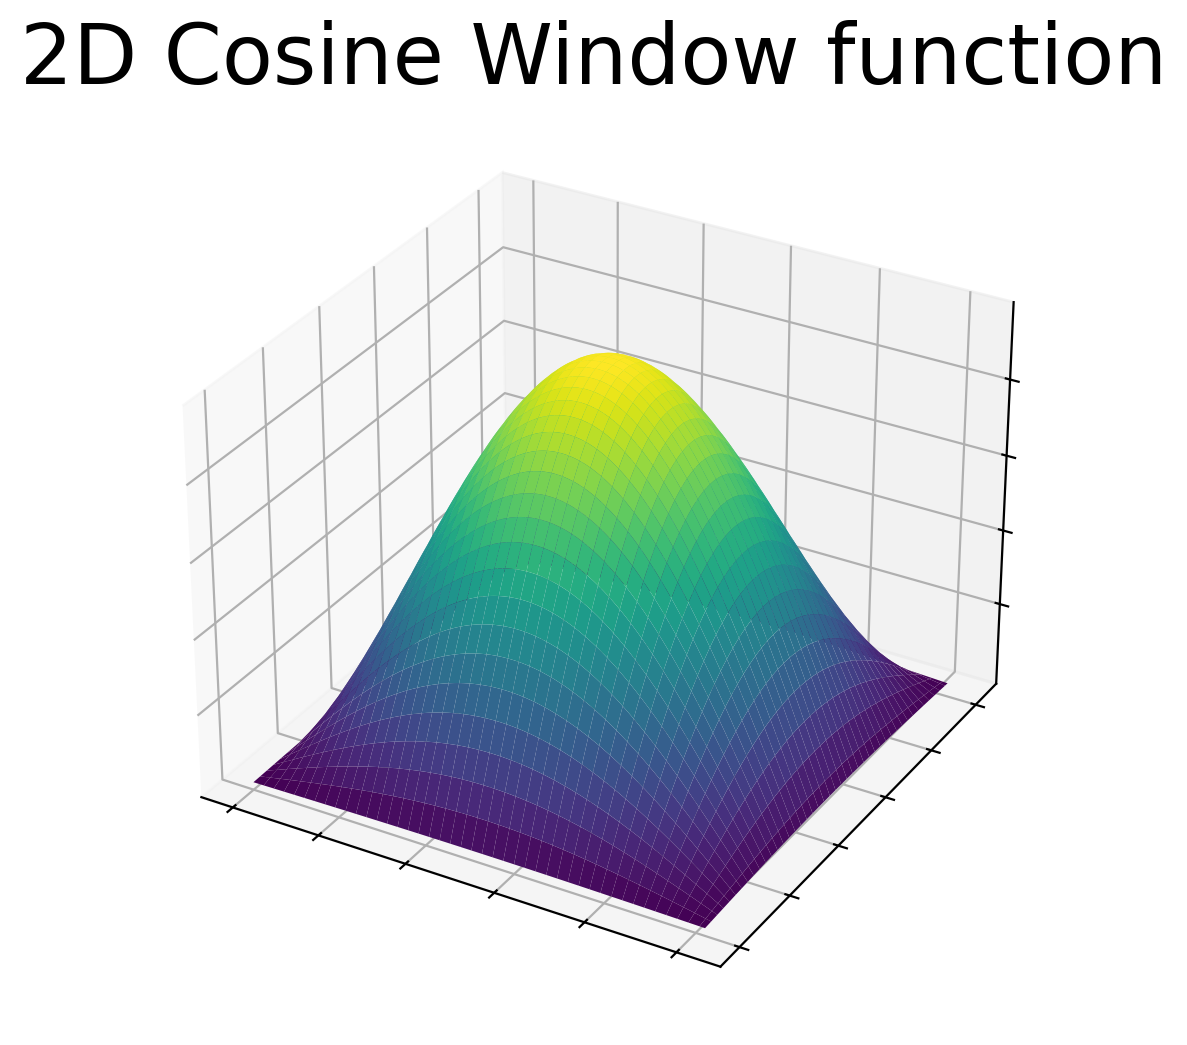

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import scipy

wind = scipy.signal.windows.get_window("cosine", 256)
wind = wind / np.average(wind)
wind = np.expand_dims(wind, 1)
wind = wind * wind.T
wind = torch.from_numpy(wind).unsqueeze(-1)

# Create a meshgrid for x and y coordinates
x = np.arange(wind.shape[0])
y = np.arange(wind.shape[1])
X, Y = np.meshgrid(x, y)

# Create a 3D plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, wind[:, :, 0], cmap='viridis')

# Customize the plot
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.set_title('2D Cosine Window function', size=30)

# Save the plot as an SVG file
plt.tight_layout()
plt.savefig('cosine_window_function.svg', format='svg', transparent=True)

plt.show()


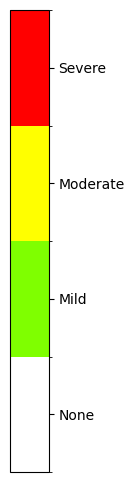

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# Define the custom colors for the discrete grades
colors = ['#FFFFFF', '#7FFF00', '#FFFF00', '#FF0000']  # Red, Green, Blue, Yellow

# Create a custom colormap with the specified colors
cmap = mpl.colors.ListedColormap(colors)

# Create a colorbar with 4 discrete grades
norm = mpl.colors.BoundaryNorm([0, 1, 2, 3, 4], cmap.N)
plt.figure(figsize=(0.5, 6))
cb = mpl.colorbar.ColorbarBase(plt.gca(), cmap=cmap, norm=norm, ticks=[0.5, 1.5, 2.5, 3.5], boundaries=[0, 1, 2, 3, 4])

# Set labels for each grade
cb.set_ticklabels(['None', 'Mild', 'Moderate', 'Severe'])

plt.show()


In [8]:
import pandas as pd

# Create DataFrame
df = pd.DataFrame({
    'exam': [1,2,3,4,5,6,7,8,9,10,11,12,13,14] * 3,
    'judge': ["csi"] * 14 + ["ljs"] * 14 + ["nji"] * 14, #+ ["ai"] * 14,
    'rating': [3.8, 10.85, 18.825, 31.225, 28.875, 3.75, 2.45, 31.925, 1.65, 1.725, 5.35, 10.65, 26.05, 10.425,
                4.075, 10.575, 10.25, 22.6, 20.7875, 5.2625, 2.025, 27.2, 2.975, 0.575, 8.8, 15.85, 20.5, 11.85,
                6.45, 22.4, 40.95, 49.35, 56.3, 10.3, 4.6, 55.35, 6.35, 2.2, 10.525, 30.25, 46.2, 16.2]
                #10.2746, 12.0232, 16.9636, 22.2808, 13.2022, 14.0263, 11.5867, 33.7187, 7.10408, 6.40476, 23.5686, 17.2754, 21.3191, 20.3221]
})

# View first five rows of DataFrame
df.head()

import pingouin as pg

icc = pg.intraclass_corr(data=df, targets='exam', raters='judge', ratings='rating')
icc.set_index('Type')

# with ai 0.562416	9.365555	13	39	2.391727e-08	[0.27, 0.81]
# only human 0.621317	11.847017	13	26	8.352493e-08	[0.18, 0.86]

,Description,ICC,F,df1,df2,pval,CI95%
Type,,,,,,,
ICC1,Single raters absolute,0.593274,5.375968,13,28,9.655630e-05,"[0.29, 0.83]"
ICC2,Single random raters,0.621317,11.847017,13,26,8.352493e-08,"[0.18, 0.86]"
ICC3,Single fixed raters,0.783347,11.847017,13,26,8.352493e-08,"[0.56, 0.92]"
ICC1k,Average raters absolute,0.813987,5.375968,13,28,9.655630e-05,"[0.55, 0.93]"
ICC2k,Average random raters,0.831143,11.847017,13,26,8.352493e-08,"[0.4, 0.95]"
ICC3k,Average fixed raters,0.915591,11.847017,13,26,8.352493e-08,"[0.79, 0.97]"


In [9]:
import pandas as pd
import pingouin as pg

results = pd.read_excel("results/Results_expert+AI.xlsx", sheet_name="종합", usecols="C,D,E,G")
results[["조수익", "나정임"]]
for raters in [["이지수", "나정임", "AI중간맛"],
               ["조수익", "나정임", "AI중간맛"],
               ["조수익", "이지수", "AI중간맛"],
               ["조수익", "이지수", "나정임"],
               ["조수익", "이지수", "나정임", "AI중간맛"]]:
    sub_results = results[raters]

    # Create DataFrame
    df = pd.DataFrame({
        'exam': [i for i in range(1, 141)] * len(raters),
        'judge': (["A"] * 140 + ["B"] * 140 + ["C"] * 140 + ["D"] * 140)[:len(raters) * 140],
        'rating': sub_results.to_numpy().T.flatten(),
    })

    # View first five rows of DataFrame
    df.head()

    print(raters)
    icc = pg.intraclass_corr(data=df, targets='exam', raters='judge', ratings='rating')
    print(icc.set_index('Type'))

    # 0.562416	9.365555	13	39	2.391727e-08	[0.27, 0.81]
    # 0.621317	11.847017	13	26	8.352493e-08	[0.18, 0.86]

['이지수', '나정임', 'AI중간맛']
                   Description       ICC         F  df1  df2          pval  \
Type                                                                         
ICC1    Single raters absolute  0.571458  5.000476  139  280  1.824617e-30   
ICC2      Single random raters  0.583627  6.286698  139  278  9.353371e-39   
ICC3       Single fixed raters  0.637974  6.286698  139  278  9.353371e-39   
ICC1k  Average raters absolute  0.800019  5.000476  139  280  1.824617e-30   
ICC2k    Average random raters  0.807880  6.286698  139  278  9.353371e-39   
ICC3k     Average fixed raters  0.840934  6.286698  139  278  9.353371e-39   

              CI95%  
Type                 
ICC1   [0.48, 0.66]  
ICC2    [0.44, 0.7]  
ICC3   [0.56, 0.71]  
ICC1k  [0.74, 0.85]  
ICC2k   [0.7, 0.87]  
ICC3k  [0.79, 0.88]  
['조수익', '나정임', 'AI중간맛']
                   Description       ICC         F  df1  df2          pval  \
Type                                                                     

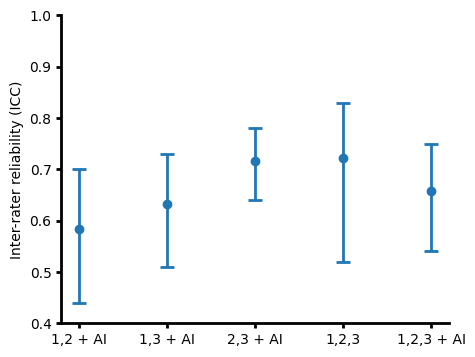

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.width'] = 2

mean = np.array([0.583627, 0.632790, 0.715248, 0.720996, 0.657124])
fig = plt.figure(figsize=(5,4))
plt.errorbar(["1,2 + AI", "1,3 + AI", "2,3 + AI", "1,2,3", "1,2,3 + AI"],
             [0.583627, 0.632790, 0.715248, 0.720996, 0.657124],
             np.abs((np.array([[0.44, 0.7], [0.51, 0.73], [0.64, 0.78], [0.52, 0.83], [0.54, 0.75]]).T - mean)),
             linestyle="none",
             marker='o',
             capsize=5,
             capthick=2,
             linewidth=2)

plt.ylim(0.4, 1)
plt.ylabel("Inter-rater reliability (ICC)")
plt.show()

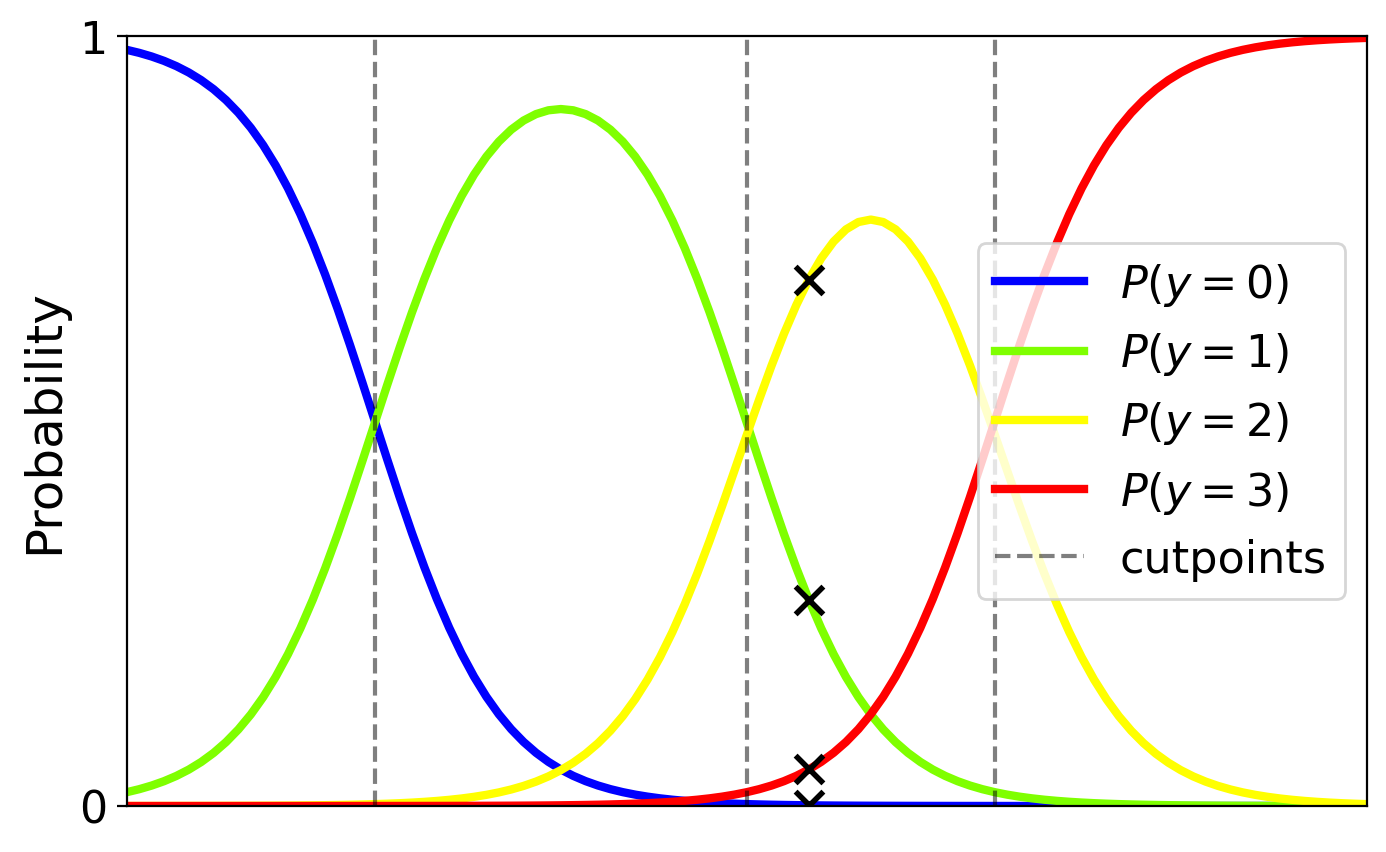

In [ ]:
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np

plt.ion()
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 16
num_points = 101
sigma = lambda f: 1 / (1 + np.exp(-f))
f = np.linspace(-10, 10, num_points)

def plot_ordinal_classes(f, cutpoints, x_value):
    num_classes = len(cutpoints) + 1
    labels = []
    y_values = []

    for idx in range(num_classes):
        if idx == 0:
            y = sigma(cutpoints[0] - f)
            plt.plot(f, y, color='b', linewidth=3)
        elif idx == 1:
            y = sigma(cutpoints[idx] - f) - sigma(cutpoints[idx - 1] - f)
            plt.plot(f, y, color='#7FFF00', linewidth=3)
        elif idx == 2:
            y = sigma(cutpoints[idx] - f) - sigma(cutpoints[idx - 1] - f)
            plt.plot(f, y, color='#FFFF00', linewidth=3)
        else:
            y = 1 - sigma(cutpoints[-1] - f)
            plt.plot(f, y, color='#FF0000', linewidth=3)

        y_values.append(y[np.isclose(f, x_value)])
        labels.append(f'$P(y = {idx})$')

    for c in cutpoints:
        plt.plot((c, c), (0, 1), 'k--', alpha=0.5)

    labels.append('cutpoints')
    plt.legend(labels)
    plt.ylabel('Probability')
    plt.xticks([])
    plt.yticks([0.0, 1.0])
    plt.xlim(-10, 10)
    plt.ylim(0, 1)

    # Plot the points where x = x_value
    for idx, y_val in enumerate(y_values):
        plt.scatter([x_value], y_val, color='k', s=100, zorder=10, marker='x', linewidths=2)

cutpoints = [-6, 0, 4]
x_value = 1
plot_ordinal_classes(f, cutpoints, x_value)
plt.savefig('ordinal_classes_plot_with_points.svg', format='svg', transparent=True)